# Phân Tích Dữ Liệu Heart Disease: Apriori & K-Means

Notebook này tích hợp toàn bộ quy trình khai phá dữ liệu:
1. **Tiền xử lý**: Rời rạc hóa và One-Hot Encoding.
2. **Luật kết hợp (Apriori)**: Tìm tập phổ biến.
3. **Phân cụm (Clustering)**: K-Means (Elbow, Silhouette) trên dữ liệu đã mã hóa.
4. **Đánh giá**: Trực quan hóa kết quả.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules

# Cấu hình hiển thị
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# Đọc dữ liệu từ file CSV
try:
    df = pd.read_csv('HeartDiseaseTrain-Test.csv')
    print("Dữ liệu gốc:")
    display(df.head())
    print(df.info())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'HeartDiseaseTrain-Test.csv'. Hãy upload file vào cùng thư mục.")

Dữ liệu gốc:


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1025 non-null   int64  
 1   sex                            1025 non-null   object 
 2   chest_pain_type                1025 non-null   object 
 3   resting_blood_pressure         1025 non-null   int64  
 4   cholestoral                    1025 non-null   int64  
 5   fasting_blood_sugar            1025 non-null   object 
 6   rest_ecg                       1025 non-null   object 
 7   Max_heart_rate                 1025 non-null   int64  
 8   exercise_induced_angina        1025 non-null   object 
 9   oldpeak                        1025 non-null   float64
 10  slope                          1025 non-null   object 
 11  vessels_colored_by_flourosopy  1025 non-null   object 
 12  thalassemia                    1025 non-null   o

## 1. Tiền xử lý (Preprocessing)
Chuyển đổi dữ liệu liên tục sang dạng phân loại (Rời rạc hóa) và sau đó mã hóa One-Hot.

In [3]:
df_clean = df.copy()

# 1. Rời rạc hóa các biến liên tục (Binning)
# Age
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 44, 54, 64, 100], labels=['Age_<45', 'Age_45-54', 'Age_55-64', 'Age_>=65'])
# Blood Pressure
df_clean['bp_group'] = pd.cut(df_clean['resting_blood_pressure'], bins=[0, 119, 139, 300], labels=['BP_Normal', 'BP_Prehypertension', 'BP_High'])
# Cholesterol
df_clean['chol_group'] = pd.cut(df_clean['cholestoral'], bins=[0, 199, 239, 600], labels=['Chol_Desirable', 'Chol_Borderline', 'Chol_High'])
# Max Heart Rate (theo tứ phân vị)
df_clean['maxhr_group'] = pd.qcut(df_clean['Max_heart_rate'], q=4, labels=['MaxHR_Q1', 'MaxHR_Q2', 'MaxHR_Q3', 'MaxHR_Q4'])
# Oldpeak
df_clean['oldpeak_group'] = pd.cut(df_clean['oldpeak'], bins=[-1, 0, 1.5, 10], labels=['Oldpeak_0', 'Oldpeak_0-1.5', 'Oldpeak_>1.5'])

# Xóa cột số gốc
cols_drop = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
df_binned = df_clean.drop(columns=cols_drop).astype(str)

# 2. Mã hóa One-Hot (Tạo ma trận nhị phân)
df_encoded = pd.get_dummies(df_binned)
print("Kích thước sau mã hóa:", df_encoded.shape)
display(df_encoded.head())

Kích thước sau mã hóa: (1025, 44)


,sex_Female,sex_Male,chest_pain_type_Asymptomatic,chest_pain_type_Atypical angina,chest_pain_type_Non-anginal pain,chest_pain_type_Typical angina,fasting_blood_sugar_Greater than 120 mg/ml,fasting_blood_sugar_Lower than 120 mg/ml,rest_ecg_Left ventricular hypertrophy,rest_ecg_Normal,...,chol_group_Chol_Borderline,chol_group_Chol_Desirable,chol_group_Chol_High,maxhr_group_MaxHR_Q1,maxhr_group_MaxHR_Q2,maxhr_group_MaxHR_Q3,maxhr_group_MaxHR_Q4,oldpeak_group_Oldpeak_0,oldpeak_group_Oldpeak_0-1.5,oldpeak_group_Oldpeak_>1.5
0,False,True,False,False,False,True,False,True,False,False,...,True,False,False,False,False,False,True,False,True,False
1,False,True,False,False,False,True,True,False,False,True,...,True,False,False,False,False,True,False,False,False,True
2,False,True,False,False,False,True,False,True,False,False,...,False,True,False,True,False,False,False,False,False,True
3,False,True,False,False,False,True,False,True,False,False,...,True,False,False,False,False,True,False,True,False,False
4,True,False,False,False,False,True,True,False,False,False,...,False,False,True,True,False,False,False,False,False,True


## 2. Tìm luật kết hợp (Apriori)
Tìm các tập phổ biến (frequent itemsets) xuất hiện cùng nhau.

In [4]:
# Tìm tập phổ biến (Support >= 0.2)
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)

print("Top 10 tập phổ biến nhất:")
display(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

# Sinh luật kết hợp (Lift >= 1)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print(f"\nTìm thấy {len(rules)} luật kết hợp. Top luật có Lift cao nhất:")
display(rules.sort_values(by='lift', ascending=False).head(5))

Top 10 tập phổ biến nhất:


,support,itemsets
4,0.850732,(fasting_blood_sugar_Lower than 120 mg/ml)
1,0.695610,(sex_Male)
7,0.663415,(exercise_induced_angina_No)
35,0.587317,"(sex_Male, fasting_blood_sugar_Lower than 120 ..."
73,0.572683,"(fasting_blood_sugar_Lower than 120 mg/ml, exe..."
12,0.563902,(vessels_colored_by_flourosopy_Zero)
13,0.530732,(thalassemia_Fixed Defect)
16,0.513171,(target_1)
22,0.504390,(chol_group_Chol_High)
6,0.500488,(rest_ecg_ST-T wave abnormality)



Tìm thấy 1380 luật kết hợp. Top luật có Lift cao nhất:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
764,(oldpeak_group_Oldpeak_0),"(slope_Downsloping, thalassemia_Fixed Defect)",0.320976,0.321951,0.210732,0.656535,2.039237,1.0,0.107393,1.974142,0.750519,0.487585,0.493451,0.65554
761,"(slope_Downsloping, thalassemia_Fixed Defect)",(oldpeak_group_Oldpeak_0),0.321951,0.320976,0.210732,0.654545,2.039237,1.0,0.107393,1.965597,0.751599,0.487585,0.491249,0.65554
370,(exercise_induced_angina_Yes),"(chest_pain_type_Typical angina, target_0)",0.336585,0.365854,0.246829,0.733333,2.004444,1.0,0.123688,2.378049,0.755348,0.541756,0.579487,0.70400
367,"(chest_pain_type_Typical angina, target_0)",(exercise_induced_angina_Yes),0.365854,0.336585,0.246829,0.674667,2.004444,1.0,0.123688,2.039184,0.790210,0.541756,0.509608,0.70400
897,"(exercise_induced_angina_Yes, fasting_blood_su...","(chest_pain_type_Typical angina, target_0)",0.278049,0.365854,0.200976,0.722807,1.975673,1.0,0.099250,2.287743,0.684040,0.453744,0.562888,0.63607


## 3. Phân cụm dữ liệu (K-Means)
Sử dụng ma trận nhị phân từ bước trên để phân nhóm bệnh nhân.

Đang chạy K-Means để tìm K tối ưu...


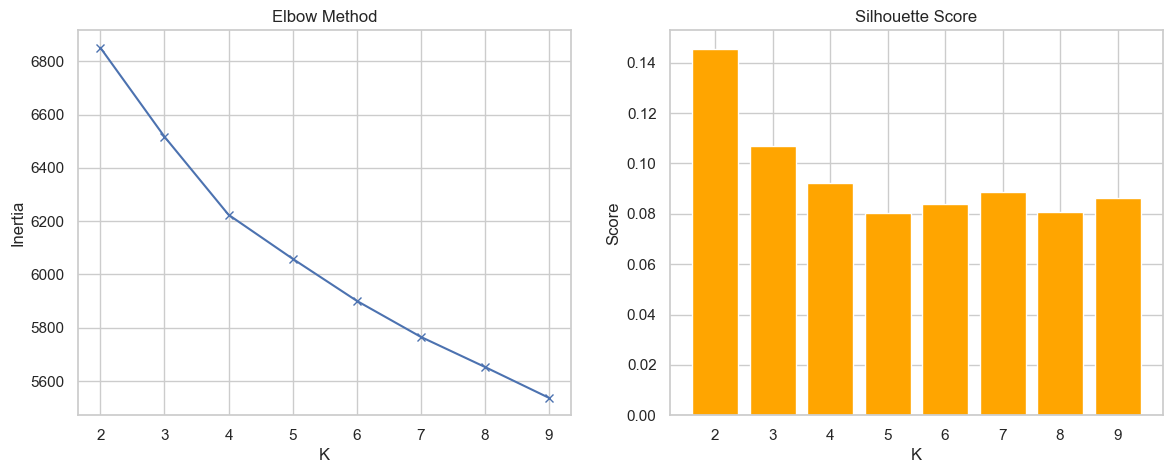

Số cụm tối ưu (Best K) theo Silhouette: 2


In [5]:
X = df_encoded.values
inertias = []
sil_scores = []
K_range = range(2, 10)

print("Đang chạy K-Means để tìm K tối ưu...")
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, km.labels_))

# Vẽ biểu đồ
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(K_range, inertias, 'bx-')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inertia')

ax[1].bar(K_range, sil_scores, color='orange')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Score')
plt.show()

best_k = K_range[np.argmax(sil_scores)]
print(f"Số cụm tối ưu (Best K) theo Silhouette: {best_k}")

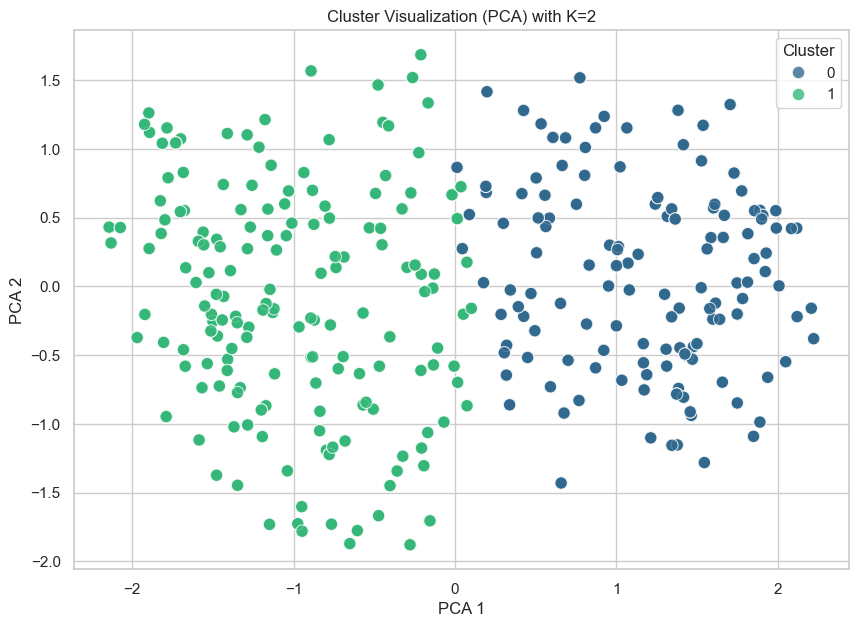

Phân bố số lượng mẫu trong các cụm:
Cluster_Label
1    554
0    471
Name: count, dtype: int64


In [6]:
# Chạy lại K-Means với Best K
final_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = final_model.fit_predict(X)

# Thêm nhãn cụm vào dữ liệu gốc
df_final = df.copy()
df_final['Cluster_Label'] = clusters

# Trực quan hóa bằng PCA (giảm chiều xuống 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis', s=80, alpha=0.8)
plt.title(f'Cluster Visualization (PCA) with K={best_k}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

print("Phân bố số lượng mẫu trong các cụm:")
print(df_final['Cluster_Label'].value_counts())